In [14]:
import numpy as np
import matplotlib.pyplot as plt
import glob, os
import tensorflow as tf
import keras 
from keras.models import Model, load_model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping,ReduceLROnPlateau
from keras import backend as K
from keras.utils import plot_model
from keras.utils import multi_gpu_model
from sklearn.model_selection import StratifiedKFold
import cv2
from skimage import io

from sklearn.metrics import roc_auc_score,confusion_matrix,accuracy_score
from sklearn.metrics import precision_recall_fscore_support,roc_curve,auc

from sklearn.model_selection import train_test_split
from keras.layers import *
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
import random
import pandas as pd
from keras import losses
from skimage.io import imsave, imread

from tensorflow.keras.applications.resnet50 import ResNet50
# from tensorflow.keras.applications.resnet152 import ResNet152

os.environ["CUDA_VISIBLE_DEVICES"] = "4,5"

In [15]:
def calculate_performance(pred, test_y):
    tp=0
    fp=0
    tn=0
    fn=0
    alpha = 0.0001
    for cm in range(len(test_y)):
        if list(test_y)[cm]==0:
            if pred[cm]<0.5:
                tn+=1
            else:
                fn+=1
        else:
            if pred[cm]<0.5:
                fp+=1
            else:
                tp+=1
    print(tp, fp, tn, fn)
    sensitivity= (tp+alpha)/(tp+fn+alpha)
    specificity= (tn+alpha)/(tn+fp+alpha) 
    acc = (tp+tn+alpha)/(tp+fp+tn+fn+alpha)
    prec = (tp+alpha)/(tp+fp+alpha)

    return tp, fp, tn, fn, sensitivity, specificity, acc, prec

In [3]:
k=5
abList = sorted(glob.glob('../../data/abnormal/*'))
nList = sorted(glob.glob('../../data/normal/*'))
split = round(len(abList)/k)
for s in range(k):
    print(s)
    a=0
    for sp in range(split):
        check = sorted(glob.glob(abList[s*sp+sp]+'/*.png'))
        a+=len(check)
    print(a)
               

0
1447
1
1597
2
1714
3
2406
4
1448


(1624, 32, 32, 1) (1624,)
StratifiedKFold(n_splits=5, random_state=None, shuffle=False)
TRAIN: 1299 TEST: 325
RETRAIN: 1300 RETEST: 324
(1300, 32, 32, 1) (324, 32, 32, 1)
163 1 0 973
TRAIN: 1299 TEST: 325
RETRAIN: 1300 RETEST: 324
(1300, 32, 32, 1) (324, 32, 32, 1)
0 164 163 1135
TRAIN: 1299 TEST: 325
RETRAIN: 1300 RETEST: 324
(1300, 32, 32, 1) (324, 32, 32, 1)
0 327 326 1298
TRAIN: 1299 TEST: 325
RETRAIN: 1300 RETEST: 324
(1300, 32, 32, 1) (324, 32, 32, 1)
0 489 488 1461
TRAIN: 1300 TEST: 324
RETRAIN: 1300 RETEST: 324
(1300, 32, 32, 1) (324, 32, 32, 1)
0 650 1461 1623


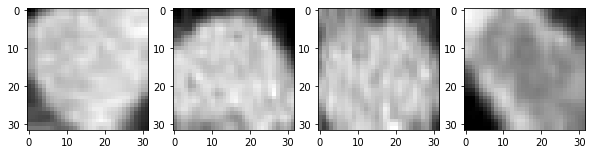

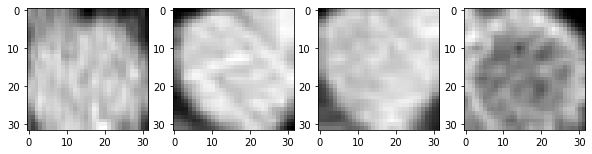

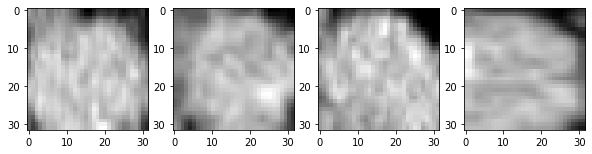

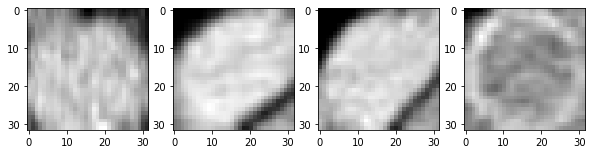

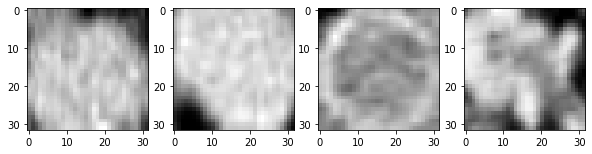

In [16]:
k=5

abnormal = np.load('../../data/npy/abnormal_16to32.npy')
normal = np.load('../../data/npy/normal_16to32.npy')
data_x = np.concatenate((normal, abnormal))
data_y = np.ndarray((len(data_x)),dtype=np.float32)
for n in range(len(data_x)):
    if n < len(normal):
        data_y[n] = 0
    else:
        data_y[n] = 1
print(data_x.shape, data_y.shape)        
# train_x,train_x,test_y,test_y = train_test_split(data_x,data_y, stratify = data_y, train_size=1300, random_state = 25)

skf = StratifiedKFold(n_splits=k)
skf.get_n_splits(data_x,data_y)
print(skf)
i=0
for train_index, test_index in skf.split(data_x,data_y):
    print("TRAIN:", len(train_index), "TEST:", len(test_index))
    indexs = np.concatenate((train_index, test_index), axis= 0)
    train_index = indexs[:1300]
    test_index = indexs[1300:]
    print("RETRAIN:", len(train_index), "RETEST:", len(test_index))
    train_x, test_x = data_x[train_index], data_x[test_index]
    train_y, test_y = data_y[train_index], data_y[test_index]
    print(train_x.shape, test_x.shape)
    plt.figure(figsize=(10,10))
    print(train_index[0],test_index[0],train_index[len(train_index)-1],test_index[len(test_index)-1])
    plt.subplot(1,4,1)
    plt.imshow(train_x[0], cmap='gray')
    plt.subplot(1,4,2)
    plt.imshow(test_x[0], cmap='gray')
    plt.subplot(1,4,3)
    plt.imshow(train_x[len(train_x)-1], cmap='gray')
    plt.subplot(1,4,4)
    plt.imshow(test_x[len(test_x)-1], cmap='gray')
 

In [22]:
def resnet_app_50(inputs):
    
    resnet = keras_resnet.models.ResNet50(inputs, include_top=False, freeze_bn=False)
    resout=resnet.outputs[3]
    
#     flatten_layer = Flatten()  
#     out = flatten_layer(resout)

    GAP_layer=GlobalAveragePooling2D()
    out = GAP_layer(resout)  
    out = Dense(1, activation="sigmoid")(out)
    
    
    model = Model(inputs=inputs, outputs=out)
    
    return model

# input_img = Input(shape=(32,32,1))    
# model = resnet_app_50(input_img)
# model.summary()

def resnet_app_34(inputs):
    
    resnet = keras_resnet.models.ResNet34(inputs, include_top=False, freeze_bn=False)
    resout=resnet.outputs[3]
    
#     flatten_layer = Flatten()  
#     out = flatten_layer(resout)

    GAP_layer=GlobalAveragePooling2D()
    out = GAP_layer(resout)  
    out = Dense(1, activation="sigmoid")(out)
    
    
    model = Model(inputs=inputs, outputs=out)
    
    return model  

def resnet_app_18(inputs):
    
    resnet = keras_resnet.models.ResNet18(inputs, include_top=False, freeze_bn=False)
    resout=resnet.outputs[3]
    
#     flatten_layer = Flatten()  
#     out = flatten_layer(resout)

    GAP_layer=GlobalAveragePooling2D()
    out = GAP_layer(resout)  
    out = Dense(1, activation="sigmoid")(out)
    
    
    model = Model(inputs=inputs, outputs=out)
    
    return model 

In [11]:
# check model and save result
i=0
performances = np.ndarray((k,4), dtype=np.float32)
for i in range(k):
    print(i)
    test_model = load_model(savepath+'/model/resnet50_app_fold{}_0512.h5'.format(str(i)))
    test_x= np.load(savepath+'/npy/test_x_fold{}.npy'.format(str(i)))
    test_y= np.load(savepath+'/npy/test_y_fold{}.npy'.format(str(i)))
    test_result= test_model.predict(test_x, batch_size=128, verbose=1)
    np.save(savepath+'/npy/test_result_fold{}.npy'.format(str(i)), test_result)
    fpr_res,tpr_res,_=roc_curve(test_y,test_result)
    auc_res=auc(fpr_res, tpr_res)
    #     print("loss: %.2f, 정확도: %.3f  " %(score[0], score[1]))
    res_tp, res_fp, res_tn, res_fn, res_sensitivity, res_specificity, acc, prec= calculate_performance(test_result, test_y)
    
    performanceList = [auc_res, res_sensitivity, res_specificity, acc]
    for a in range(4):
        performances[i][a] = performanceList[a]
    
#     interp_tpr = np.interp(mean_fpr, _, _)
#     interp_tpr[0] = 0.0
#     tprs.append(interp_tpr)
#     np.save('./210512/npy/performanceList_fold{}.npy'.format(str(i)), performances)
    print('###########RESULT########')
    print('AUC:{}, SEN:{}, SPEC:{}, ACC:{}, PREC:{}'.format(round(auc_res,3),round(res_sensitivity,3),round(res_specificity,3),round(acc,3),round(prec,3)))
    print('TP:{}, FP:{}. TN:{}, FN:{}'.format(res_tp, res_fp, res_tn, res_fn))
    print('#########################')
    i=+1
np.save(savepath+'/npy/performanceList.npy', performances)
all_perform = pd.DataFrame(performances)
all_perform.to_csv(savepath+'/result/all_resnonebottle3Filter4_perform.csv')

0
325/325 [==============================] - 12s 37ms/step
146 16 160 3
###########RESULT########
AUC:0.991, SEN:0.98, SPEC:0.909, ACC:0.942, PREC:146.0
TP:146, FP:16. TN:160, FN:3
#########################
1
325/325 [==============================] - 14s 43ms/step
143 19 160 3
###########RESULT########
AUC:0.987, SEN:0.979, SPEC:0.894, ACC:0.932, PREC:143.0
TP:143, FP:19. TN:160, FN:3
#########################
2
325/325 [==============================] - 16s 48ms/step
151 12 146 16
###########RESULT########
AUC:0.959, SEN:0.904, SPEC:0.924, ACC:0.914, PREC:151.0
TP:151, FP:12. TN:146, FN:16
#########################
3
325/325 [==============================] - 17s 53ms/step
115 48 161 1
###########RESULT########
AUC:0.989, SEN:0.991, SPEC:0.77, ACC:0.849, PREC:115.0
TP:115, FP:48. TN:161, FN:1
#########################
4
324/324 [==============================] - 20s 61ms/step
156 6 147 15
###########RESULT########
AUC:0.985, SEN:0.912, SPEC:0.961, ACC:0.935, PREC:156.0
TP:156, FP:6. 

0
149 13 163 0
###########RESULT########
AUC:0.998, SEN:1.0, SPEC:0.926, ACC:0.96, PREC:149.0
TP:149, FP:13. TN:163, FN:0
#########################
1
160 2 161 2
###########RESULT########
AUC:1.0, SEN:0.988, SPEC:0.988, ACC:0.988, PREC:160.0
TP:160, FP:2. TN:161, FN:2
#########################
2
149 14 152 10
###########RESULT########
AUC:0.964, SEN:0.937, SPEC:0.916, ACC:0.926, PREC:149.0
TP:149, FP:14. TN:152, FN:10
#########################
3
162 1 162 0
###########RESULT########
AUC:1.0, SEN:1.0, SPEC:0.994, ACC:0.997, PREC:162.0
TP:162, FP:1. TN:162, FN:0
#########################
4
162 0 142 20
###########RESULT########
AUC:0.991, SEN:0.89, SPEC:1.0, ACC:0.938, PREC:162.0
TP:162, FP:0. TN:142, FN:20
#########################
[0.9910074683737236, 0.8901099504890382, 1.0, 0.9382716239902396]


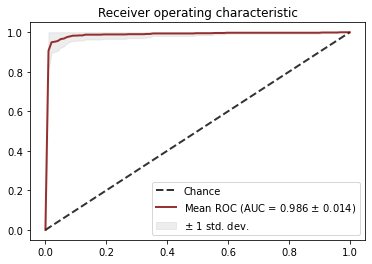

<Figure size 720x720 with 0 Axes>

In [8]:
#plot
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

# performances = np.ndarray((k,4), dtype=np.float32)
for i in range(k):
    print(i)
#     test_model = load_model(savepath+'/model/residual3_filter4_fold{}_0512.h5'.format(str(i)))
    test_x= np.load(savepath+'/npy/test_x_fold{}.npy'.format(str(i)))
    test_y= np.load(savepath+'/npy/test_y_fold{}.npy'.format(str(i)))
    test_result= np.load(savepath+'/npy/test_result_fold{}.npy'.format(str(i)))
#     np.save(savepath+'/npy/test_result_fold{}.npy'.format(str(i)), test_result)
    fpr_res,tpr_res,_=roc_curve(test_y,test_result)
    auc_res=auc(fpr_res, tpr_res)
    #     print("loss: %.2f, 정확도: %.3f  " %(score[0], score[1]))
    res_tp, res_fp, res_tn, res_fn, res_sensitivity, res_specificity, acc, prec= calculate_performance(test_result, test_y)
    
    performanceList = [auc_res, res_sensitivity, res_specificity, acc]
    for a in range(4):
        performances[i][a] = performanceList[a]
    
#     interp_tpr = np.interp(mean_fpr, _, _)
#     interp_tpr[0] = 0.0
#     tprs.append(interp_tpr)
#     np.save('./210512/npy/performanceList_fold{}.npy'.format(str(i)), performances)
    print('###########RESULT########')
    print('AUC:{}, SEN:{}, SPEC:{}, ACC:{}, PREC:{}'.format(round(auc_res,3),round(res_sensitivity,3),round(res_specificity,3),round(acc,3),round(prec,3)))
    print('TP:{}, FP:{}. TN:{}, FN:{}'.format(res_tp, res_fp, res_tn, res_fn))
    print('#########################')
#     i=+1

    interp_tpr = np.interp(mean_fpr, fpr_res,tpr_res)
    interp_tpr[0] = 0.0

    tprs.append(interp_tpr)
    aucs.append(auc_res)
# print(XGB_result)
print(performanceList)
fig, ax = plt.subplots()
fig = plt.figure(figsize=(10,10))

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='black',
        label='Chance', alpha=.8)

mean_tpr_xgb = np.mean(tprs, axis=0)
mean_tpr_xgb[-1] = 1.0
mean_auc_xgb = auc(mean_fpr, mean_tpr_xgb)
std_auc_xgb = np.std(aucs)
ax.plot(mean_fpr, mean_tpr_xgb, color='maroon',
        label=r'Mean ROC (AUC = %0.3f $\pm$ %0.3f)' % (mean_auc_xgb, std_auc_xgb),
        lw=2, alpha=.8)

std_tpr_xgb = np.std(tprs, axis=0)
tprs_upper_xgb = np.minimum(mean_tpr_xgb + std_tpr_xgb, 1)
tprs_lower_xgb = np.maximum(mean_tpr_xgb - std_tpr_xgb, 0)
ax.fill_between(mean_fpr, tprs_lower_xgb, tprs_upper_xgb, color='darkgray', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="Receiver operating characteristic")
ax.legend(loc="lower right")
# fig.savefig('./result/0512/LR_embedded_cv5.jpg')
# plt.figure(figsize=(20,20))
plt.show()
fig.savefig(savepath+'/result/resCNN_cv5_first.jpg', dpi=300)

np.save(savepath+'/result/mean_tpr_resCNN_nonebottleRes34Filter4_0512.npy', mean_tpr_xgb)

0
146 16 160 3
###########RESULT########
AUC:0.991, SEN:0.98, SPEC:0.909, ACC:0.942, PREC:146.0
TP:146, FP:16. TN:160, FN:3
#########################
1
143 19 160 3
###########RESULT########
AUC:0.987, SEN:0.979, SPEC:0.894, ACC:0.932, PREC:143.0
TP:143, FP:19. TN:160, FN:3
#########################
2
151 12 146 16
###########RESULT########
AUC:0.959, SEN:0.904, SPEC:0.924, ACC:0.914, PREC:151.0
TP:151, FP:12. TN:146, FN:16
#########################
3
115 48 161 1
###########RESULT########
AUC:0.989, SEN:0.991, SPEC:0.77, ACC:0.849, PREC:115.0
TP:115, FP:48. TN:161, FN:1
#########################
4
156 6 147 15
###########RESULT########
AUC:0.985, SEN:0.912, SPEC:0.961, ACC:0.935, PREC:156.0
TP:156, FP:6. TN:147, FN:15
#########################


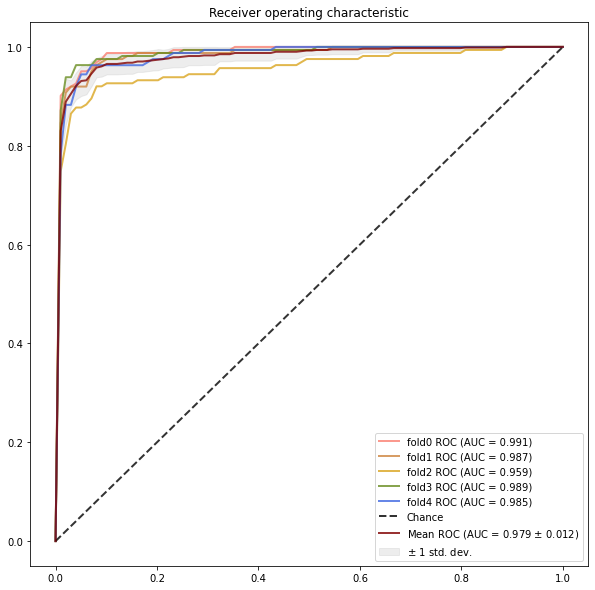

In [12]:
############################Here!!
k=5
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
colors = ['salmon', 'peru', 'goldenrod', 'olivedrab', 'royalblue']
# fig=plt.figure(figsize=(20,20))
fig, ax = plt.subplots(figsize=(10,10))
# performances = np.ndarray((k,4), dtype=np.float32)
for i in range(k):
    print(i)
#     test_model = load_model(savepath+'/model/residual3_filter4_fold{}_0512.h5'.format(str(i)))
    test_x= np.load(savepath+'/npy/test_x_fold{}.npy'.format(str(i)))
    test_y= np.load(savepath+'/npy/test_y_fold{}.npy'.format(str(i)))
    test_result= np.load(savepath+'/npy/test_result_fold{}.npy'.format(str(i)))
#     np.save(savepath+'/npy/test_result_fold{}.npy'.format(str(i)), test_result)
    fpr_res,tpr_res,_=roc_curve(test_y,test_result)
    auc_res=auc(fpr_res, tpr_res)
    #     print("loss: %.2f, 정확도: %.3f  " %(score[0], score[1]))
    res_tp, res_fp, res_tn, res_fn, res_sensitivity, res_specificity, acc, prec= calculate_performance(test_result, test_y)
    
    performanceList = [auc_res, res_sensitivity, res_specificity, acc]
    for a in range(4):
        performances[i][a] = performanceList[a]
    
#     interp_tpr = np.interp(mean_fpr, _, _)
#     interp_tpr[0] = 0.0
#     tprs.append(interp_tpr)
#     np.save('./210512/npy/performanceList_fold{}.npy'.format(str(i)), performances)
    print('###########RESULT########')
    print('AUC:{}, SEN:{}, SPEC:{}, ACC:{}, PREC:{}'.format(round(auc_res,3),round(res_sensitivity,3),round(res_specificity,3),round(acc,3),round(prec,3)))
    print('TP:{}, FP:{}. TN:{}, FN:{}'.format(res_tp, res_fp, res_tn, res_fn))
    print('#########################')
#     i=+1

    interp_tpr = np.interp(mean_fpr, fpr_res,tpr_res)
    interp_tpr[0] = 0.0
    
#     fig, ax = plt.subplots()
    
    ax.plot(mean_fpr, interp_tpr, color=colors[i],
        label=r'fold%s ROC (AUC = %0.3f)' % (str(i),auc_res),
        lw=2, alpha=.8)

    tprs.append(interp_tpr)
    aucs.append(auc_res)
    
# fig, ax = plt.subplots()
# fig = plt.figure(figsize=(10,10))

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='black',
        label='Chance', alpha=.8)

mean_tpr_xgb = np.mean(tprs, axis=0)
mean_tpr_xgb[-1] = 1.0
mean_auc_xgb = auc(mean_fpr, mean_tpr_xgb)
std_auc_xgb = np.std(aucs)
ax.plot(mean_fpr, mean_tpr_xgb, color='maroon',
        label=r'Mean ROC (AUC = %0.3f $\pm$ %0.3f)' % (mean_auc_xgb, std_auc_xgb),
        lw=2, alpha=.8)
# ax.plot(mean_fpr, interp_tpr, color='navy',
#         label=r'Mean ROC (AUC = %0.3f)' % (auc_res),
#         lw=2, alpha=.8)

std_tpr_xgb = np.std(tprs, axis=0)
tprs_upper_xgb = np.minimum(mean_tpr_xgb + std_tpr_xgb, 1)
tprs_lower_xgb = np.maximum(mean_tpr_xgb - std_tpr_xgb, 0)
ax.fill_between(mean_fpr, tprs_lower_xgb, tprs_upper_xgb, color='darkgray', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="Receiver operating characteristic")
ax.legend(loc="lower right")
# fig.savefig('./result/0512/LR_embedded_cv5.jpg')
# plt.figure(figsize=(20,20))
plt.show()
fig.savefig(savepath+'/result/basicCNN_cv5_first.jpg', dpi=300)

np.save(savepath+'/result/mean_tpr_basicCNN_0512.npy', mean_tpr_xgb)